In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from typing import Callable, Dict, Tuple, Optional, Union

import warnings
warnings.filterwarnings('ignore')

class RobustQLEVolatilityModel:
    
    
    def __init__(self, alpha_loss: float = None, c: float = None):
        
        self.alpha_loss = alpha_loss
        self.c = c
        self.params = None
        self.param_names = ['omega', 'gamma', 'beta']
        if alpha_loss is None:
            self.param_names.append('alpha_loss')
        if c is None:
            self.param_names.append('c')
        self.fitted_volatility = None
        self.residuals = None
    
    def _rho_derivative(self, e: np.ndarray, alpha: float, c: float) -> np.ndarray:
        
        # Handle scalar inputs by converting to numpy arrays
        if np.isscalar(e):
            e = np.array([e])
            scalar_input = True
        else:
            scalar_input = False
            
        if alpha == 2:
            # L2 loss (least squares)
            result = e / (c**2)
        elif alpha == 0:
            # Cauchy/Lorentzian loss
            result = (2 * e) / (e**2 + 2 * c**2)
        elif alpha == float('-inf'):
            # Welsch/Leclerc loss
            result = (e / c**2) * np.exp(-0.5 * (e/c)**2)
        else:
            # General case
            result = (e / c**2) * np.power((e**2 / c**2) / np.abs(alpha-2) + 1, alpha/2 - 1)
        
        # Return scalar if input was scalar
        if scalar_input:
            return result[0]
        return result
    
    
    def _rho_second_derivative(self, e: np.ndarray, alpha: float, c: float) -> np.ndarray:
        
        # Handle scalar inputs by converting to numpy arrays
        if np.isscalar(e):
            e = np.array([e])
            scalar_input = True
        else:
            scalar_input = False
            
        if alpha == 2:
            # L2 loss (least squares)
            result = -np.ones_like(e) / (c**2)
        elif alpha == 0:
            # Cauchy/Lorentzian loss
            denom = (e**2 + 2 * c**2)**2
            result = -(2*(e**2 + 2* c**2) - 4 * e **2) / denom
        elif alpha == float('-inf'):
            # Welsch/Leclerc loss
            first_term = ((e)**2 * np.exp( -((e**2)/(2* (c**2)))))/(c**4)
            second_term = np.exp( -((e**2)/(2* (c**2))))/(c**2)
            result = (first_term - second_term)
        else:
            # General case
            e2 = (e)**2
            denom = c**2 * np.abs(alpha - 2)
            A = e2 / denom + 1

            term1 = -2 * (alpha/2 - 1) * A**(alpha/2 - 2) * e2
            term1 /= (c**4 * np.abs(alpha - 2))

            term2 = - A**(alpha/2 - 1) / (c**2)

            return term1 + term2
            
        
        # Return scalar if input was scalar
        if scalar_input:
            return result[0]
        return result
        
    def dpsi_dalpha(self, e_t, c, alpha_loss):
        
        # define a small neighborhood around the problematic points:
        eps = 1e-4

        # if α is within ±eps of 2, treat it as exactly 2 (L2 case)
        if abs(alpha_loss - 2) < eps:
            delta = 1e-5
            psi_plus = self._rho_derivative(e_t, alpha_loss + delta, self.c) 
            psi_minus = self._rho_derivative(e_t, alpha_loss - delta, self.c) 
            dpsi_dalpha = (psi_plus - psi_minus) / (2 * delta)
            return dpsi_dalpha  # ∂ψ/∂α = 0 for the L2 loss

        # similarly guard α≈0
        if abs(alpha_loss - 0) < eps:
            # use the closed-form ∂ψ/∂α at α=0 (which you've already set to 0)
            delta = 1e-5
            psi_plus = self._rho_derivative(e_t, alpha_loss + delta, self.c) 
            psi_minus = self._rho_derivative(e_t, alpha_loss - delta, self.c) 
            dpsi_dalpha = (psi_plus - psi_minus) / (2 * delta)
            return dpsi_dalpha

        # if you ever parameterize "α = −∞" as, say, alpha_loss < some negative cutoff
        if alpha_loss < -1e3:
            delta = 1e-5
            psi_plus = self._rho_derivative(e_t, alpha_loss + delta, self.c) 
            psi_minus = self._rho_derivative(e_t, alpha_loss - delta, self.c)
            dpsi_dalpha = (psi_plus - psi_minus) / (2 * delta)
            return dpsi_dalpha  

        # otherwise you're safely away from the singularities, so use your general formula:
        alpha= alpha_loss
        e2 = e_t**2
        denom = c**2 * np.abs(alpha - 2)
        A = (e2 / denom) + 1

        # Compute the bracket term
        term_log = np.log(A) / 2
        term_frac = (e2 * (alpha/2 - 1)) / (c**2 * A * np.abs(alpha - 2) * (alpha - 2))
        bracket = term_log - term_frac

        # Combine everything
        result = (e_t * A**(alpha/2 - 1) * bracket) / (c**2)
        return result

    
    
    def dpsi_dc(self, e_t, c, alpha_loss):
       
        eps = 1e-4

        if alpha_loss == 2:
            # dψ/dc = -2e / c³
            return -2 * e_t / c**3

        elif abs(alpha_loss) < eps:
            # dψ/dc = -8ec / (e² + 2c²)²
            return -8 * e_t * c / (e_t**2 + 2 * c**2)**2

        elif alpha_loss < -1e3:
            # dψ/dc = ( -2e / c³ + e³ / c⁵ ) * exp(-½ (e/c)²)
            z = e_t / c
            exp_term = np.exp(-0.5 * z**2)
            return (-2 * e_t / c**3 + e_t**3 / c**5) * exp_term

        else:
            alpha = alpha_loss
            e2 = e_t**2
            denom = np.abs(alpha - 2) * c**2
            A = e2 / denom + 1

            term1 = -2 * e_t * A**(alpha/2 - 1) / (c**3)
            term2 = -2 * e_t**3 * (alpha/2 - 1) * A**(alpha/2 - 2) / (np.abs(alpha - 2) * c**5)
            
            return term1 + term2
            # General case:
            
    
    def _filter_volatility(self, y: np.ndarray, params: np.ndarray) -> np.ndarray:
        
        T = len(y)
        omega, gamma, beta = params[:3]
        
        param_idx = 3
        
        # Get alpha_loss parameter
        if self.alpha_loss is None:
            alpha_loss = params[param_idx]
            param_idx += 1
        else:
            alpha_loss = self.alpha_loss
        
        # Get c parameter
        if self.c is None:
            c = params[param_idx]
        else:
            c = self.c
        
        # Initialize volatility with the unconditional variance
        f = np.zeros(T+1)
        f[0] = omega/(1-beta)
        
        # Recursively update the volatility
        for t in range(T):
            e_t = y[t]**2 - f[t]
            psi_t = self._rho_derivative(e_t, alpha_loss, c)   
            f[t+1] = omega + gamma * psi_t + beta * f[t]
            
            # Enforce positive volatility
            f[t+1] = max(f[t+1], 1e-12)
        
        return f[1:]
    
    def _compute_derivatives(self, y: np.ndarray, f: np.ndarray, params: np.ndarray) -> np.ndarray:
       
        T = len(y)
        omega, gamma, beta = params[:3]
        
        param_idx = 3
        n_params = 3
        
        # Get alpha_loss parameter
        if self.alpha_loss is None:
            alpha_loss = params[param_idx]
            param_idx += 1
            n_params += 1
        else:
            alpha_loss = self.alpha_loss
        
        # Get c parameter
        if self.c is None:
            c = params[param_idx]
            n_params += 1
        else:
            c = self.c
        
        # Initialize derivatives of f_t with respect to theta
        e0 = y[0]**2 - f[0]
        psi0 =  self._rho_derivative(e0, alpha_loss, c)
        d2psi0_df = self._rho_second_derivative(e0, alpha_loss, c) 
        df_dtheta = np.zeros((T, n_params))
        df_dtheta[0, 0] = 1                  # ∂f₁/∂ω
        df_dtheta[0, 1] = psi0               # ∂f₁/∂γ
        df_dtheta[0, 2] = f[0]               # ∂f₁/∂β
        
        # Initialize derivatives for alpha_loss and c if they are estimated
        param_idx = 3
        
        if self.alpha_loss is None:
            dpsi0_dalpha = self.dpsi_dalpha(e0, c, alpha_loss)
            df_dtheta[0, param_idx] = gamma * dpsi0_dalpha  # ∂f₁/∂α
            param_idx += 1
        
        if self.c is None:
            dpsi0_dc = self.dpsi_dc(e0, c, alpha_loss)
            df_dtheta[0, param_idx] = gamma * dpsi0_dc  # ∂f₁/∂c
    
        # According to the recursive formula:
        
        for t in range(1, T):
            e_t = (y[t-1]**2 - f[t-1])
            psi_t = self._rho_derivative(e_t, alpha_loss, c)  
            d2psi_df = self._rho_second_derivative(e_t, alpha_loss, c)   
            
            # Common term in recursive updates
            common_term = gamma * d2psi_df + beta
            
            # Derivative with respect to parameters
            # For omega (∂ω/∂θ_0 = 1, else 0)
            df_dtheta[t, 0] = 1 + df_dtheta[t-1, 0] * common_term
            
            # For gamma (∂γ/∂θ_1 = 1, else 0)
            df_dtheta[t, 1] = psi_t + df_dtheta[t-1, 1] * common_term
            
            # For beta (∂β/∂θ_2 = 1, else 0)
            df_dtheta[t, 2] = f[t-1] + df_dtheta[t-1, 2] * common_term
            
            # Reset param_idx for additional parameters
            param_idx = 3
            
            # Derivative with respect to alpha_loss, if applicable
            if self.alpha_loss is None:
                dpsi_dalpha = self.dpsi_dalpha(e_t, c, alpha_loss)
                df_dtheta[t, param_idx] = gamma * dpsi_dalpha + common_term * df_dtheta[t-1, param_idx]
                param_idx += 1
            
            # Derivative with respect to c, if applicable
            if self.c is None:
                dpsi_dc = self.dpsi_dc(e_t, c, alpha_loss)
                df_dtheta[t, param_idx] = gamma * dpsi_dc + common_term * df_dtheta[t-1, param_idx]
        
        return df_dtheta
    
    def _qle_objective(self, params: np.ndarray, y: np.ndarray) -> float:
        
        try:
            # Apply parameter constraints
            param_idx = 3
            
            if self.alpha_loss is None:
                # Ensure alpha_loss is in reasonable range
                if params[param_idx] < -10 or params[param_idx] > 10:
                    return 1e10
                param_idx += 1
            
            if self.c is None:
                # Ensure c is positive and reasonable
                if params[param_idx] <= 0 or params[param_idx] > 10:
                    return 1e10
            
            # Basic parameter constraints for volatility model stability
            if params[0] <= 0 or params[1] < 0 or params[2] < 0 or params[2] >= 1 or params[1] + params[2] >= 0.999:
                return 1e10
            
            # Filter volatility
            f = self._filter_volatility(y, params)
            
            # Compute residuals - h_t is defined as y_t^k - f_t(θ)
            h_t = y**2 - f
            
            # Use f as the conditional variance approximation
            sigma2_t = f
            
            # Compute derivatives of f_t with respect to parameters
            df_dtheta = self._compute_derivatives(y, f, params)
            
            # G_t(θ) = (1/T) * sum[ h_t(θ) / σ²_t(θ) * ∂f_t(θ)/∂θ ]
            G_t = np.sum(h_t.reshape(-1, 1) / sigma2_t.reshape(-1, 1) * df_dtheta, axis=0) / len(y)
            
            # The objective is to minimize ||G_t(θ)||²
            obj = np.linalg.norm(G_t)
            
            return obj
        except Exception as e:
            print(f"Error in objective function: {e}")
            return 1e10
    
    def fit(self, y: np.ndarray, initial_params: Optional[Dict] = None, 
            method: str = 'Nelder-Mead', maxiter: int = 2000) -> Dict:
        
        # Set default initial parameters if not provided
        if initial_params is None:
            initial_params = {
                'omega': 0.07, 
                'gamma': 0.11, 
                'beta': 0.8
            }
            if self.alpha_loss is None:
                initial_params['alpha_loss'] = 0.9  # Default value close to Cauchy loss
            
            if self.c is None:
                initial_params['c'] = 1.2  # Default value for scale parameter
        
        # Prepare initial parameter array
        init_params = np.array([initial_params[name] for name in self.param_names])
        
        # Run optimization
        options = {'maxiter': maxiter, 'disp': True}
        
        # Different optimization methods may work better in different cases
        if method == 'Nelder-Mead':
            options['adaptive'] = True  # Use adaptive Nelder-Mead for better convergence
            result = minimize(
                self._qle_objective, 
                init_params, 
                args=(y,), 
                method=method, 
                options=options,
            )
        elif method == 'BFGS':
            options = {'maxiter': maxiter, 'gtol': 1e-6}
            result = minimize(
                self._qle_objective, 
                init_params, 
                args=(y,), 
                method=method, 
                options=options,
            )
        elif method == 'differential_evolution':
            # Set up bounds for differential evolution
            bounds = []
            
            # Basic parameters bounds
            bounds.extend([(0.001, 0.5), (0.001, 0.5), (0.6, 0.999)])
            
            # Alpha bounds if estimated
            if self.alpha_loss is None:
                bounds.append((-5, 5))
            
            # c bounds if estimated
            if self.c is None:
                bounds.append((0.1, 5.0))
            
            result = differential_evolution(
                self._qle_objective,
                bounds=bounds,
                args=(y,),
                strategy='best1bin',
                maxiter=maxiter,
                disp=True,
                polish=True
            )
        
        if not result.success and method != 'differential_evolution':
            print(f"Warning: Optimization did not converge: {result.message}")
            
            # Try again with different method if first one failed
            if method == 'Nelder-Mead':
                print("Trying BFGS method instead...")
                result = minimize(
                    self._qle_objective,
                    init_params,
                    args=(y,),
                    method='BFGS',
                    options={'maxiter': maxiter}
                )
        
        # Store parameters
        self.params = {name: val for name, val in zip(self.param_names, result.x)}
        
        # Compute fitted volatility
        param_array = np.array([self.params[name] for name in self.param_names])
        self.fitted_volatility = self._filter_volatility(y, param_array)
        self.residuals = y**2 - self.fitted_volatility
        
        print(f"Optimization result: {result.message}")
        print(f"Parameters: {self.params}")
        
        return self.params
    
    
    
    def plot_volatility(self, y: np.ndarray, true_vol: np.ndarray = None, title: str = "Estimated Volatility") -> None:
        
        if self.fitted_volatility is None:
            raise ValueError("Model must be fit before plotting")
        
        plt.figure(figsize=(12, 8))
        
        # Plot original data
        plt.subplot(2, 1, 1)
        plt.plot(y, 'b-', alpha=0.5, label='Returns')
        plt.title(title)
        plt.legend()
        
        # Plot volatility
        plt.subplot(2, 1, 2)
        plt.plot(np.sqrt(self.fitted_volatility), 'r-', label='Estimated Volatility')
        
        if true_vol is not None:
            plt.plot(np.sqrt(true_vol), 'b-', alpha=0.3, label='True Volatility')
        
        plt.legend()
        plt.ylim(0, np.max(np.sqrt(self.fitted_volatility)) * 1.5)
        plt.tight_layout()
        plt.show()
    
    def simulate(self, T: int, dist: str = 't', df: int = 5, seed: int = None) -> Tuple[np.ndarray, np.ndarray]:
        
        if self.params is None:
            raise ValueError("Parameters must be set before simulation")
        
        if seed is not None:
            np.random.seed(seed)
        
        omega = self.params['omega']
        gamma = self.params['gamma']
        beta = self.params['beta']
        
        if self.alpha_loss is None:
            alpha_loss = self.params['alpha_loss']
        else:
            alpha_loss = self.alpha_loss
        
        if self.c is None:
            c = self.params['c']
        else:
            c = self.c
        
        # Initialize arrays
        y = np.zeros(T)
        f = np.zeros(T+1)
        f[0] = omega / (1 - beta)  # Start at unconditional variance
        
        # Generate innovations
        if dist == 't':
            eps = np.random.standard_t(df, T)
        else:
            eps = np.random.normal(0, 1, T)
            
        # Generate data
        for t in range(T):
            # Generate return
            y[t] = np.sqrt(f[t]) * eps[t]
            
            # Compute the score
            e_t = (y[t]**2 - f[t])
            psi_t = self._rho_derivative(e_t, alpha_loss, c) 
            
            # Update volatility
            f[t+1] = omega + gamma * psi_t + beta * f[t]
            #f[t+1] = max(f[t+1], 1e-12)  # Ensure positive volatility
            
        return y, f[1:]

In [22]:
import numpy as np
import matplotlib.pyplot as plt


# Step 1: Simulate data
true_params = {'omega': 0.07, 'gamma': 0.11, 'beta': 0.80, 'alpha_loss': 1, 'c': 1.2}
sim_model = RobustQLEVolatilityModel(alpha_loss=true_params['alpha_loss'], c=true_params['c'])
sim_model.params = true_params
y, _ = sim_model.simulate(T=500, dist='t', df=7, seed=0)

# Step 2: Fix omega, gamma, beta
omega = 0.07
gamma = 0.11
beta = 0.80

# Step 3: Evaluate objective over a grid of alpha_loss and c
alphas = np.linspace(-2, 4, 100)
cs = np.linspace(0.5, 2.5, 100)
loss_grid = np.zeros((len(cs), len(alphas)))

# Important fix: declare model with alpha_loss=None, c=None so they are pulled from params


for i, c_val in enumerate(cs):
    for j, alpha_val in enumerate(alphas):
        model = RobustQLEVolatilityModel(alpha_loss=alpha_val, c=c_val)
        params = np.array([omega, gamma, beta, alpha_val, c_val])
        loss_grid[i, j] = model._qle_objective(params, y)

# Step 4: Plot the contour
plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(alphas, cs)
cp = plt.contourf(X, Y, loss_grid, levels=50, cmap='viridis')
plt.colorbar(cp)
plt.xlabel(r'$\alpha_{loss}$')
plt.ylabel('c')
plt.title('QLE Objective Function Landscape over alpha_loss and c')
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

EMPIRICAL ILLUSTRATION: Nord Pool Electricity Spot Prices
QUARTILE-BASED ANALYSIS
Analyzing quartile electricity spot prices - 4 observations per day
Each day split into 6-hour periods for enhanced temporal resolution
--------------------------------------------------------------------------------
Loading Nord Pool electricity spot price data from: /Users/MathijsDijkstra/Downloads/Elspotprices.csv
Methodology: Daily quartile time-series by taking mean spot price for each 6-hour period
Data loaded successfully. Shape: (50831, 5)
Date range: 2017-01-01 00:00 to 2022-10-19 23:00
Converting price columns to numeric...
Price conversion complete. DKK NAs: 0, EUR NAs: 0
Available price areas: ['DK2']
Filtered for DK2. Remaining rows: 50831
Date filtered data. Remaining rows: 5831
Daily quartile assignment:
Quartile 1: 00:00-05:59 (Night/Early Morning)
Quartile 2: 06:00-11:59 (Morning)
Quartile 3: 12:00-17:59 (Afternoon)
Quartile 4: 18:00-23:59 (Evening/Night)
Quartile observations: 972 (shoul

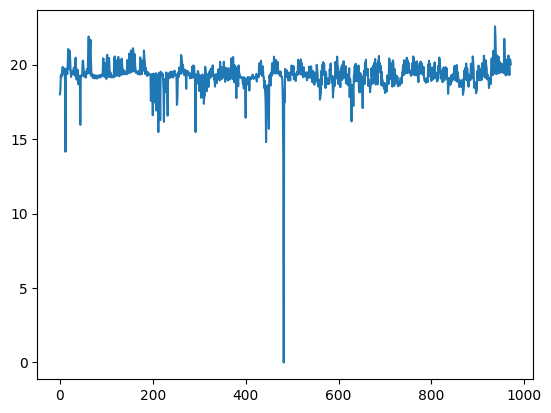

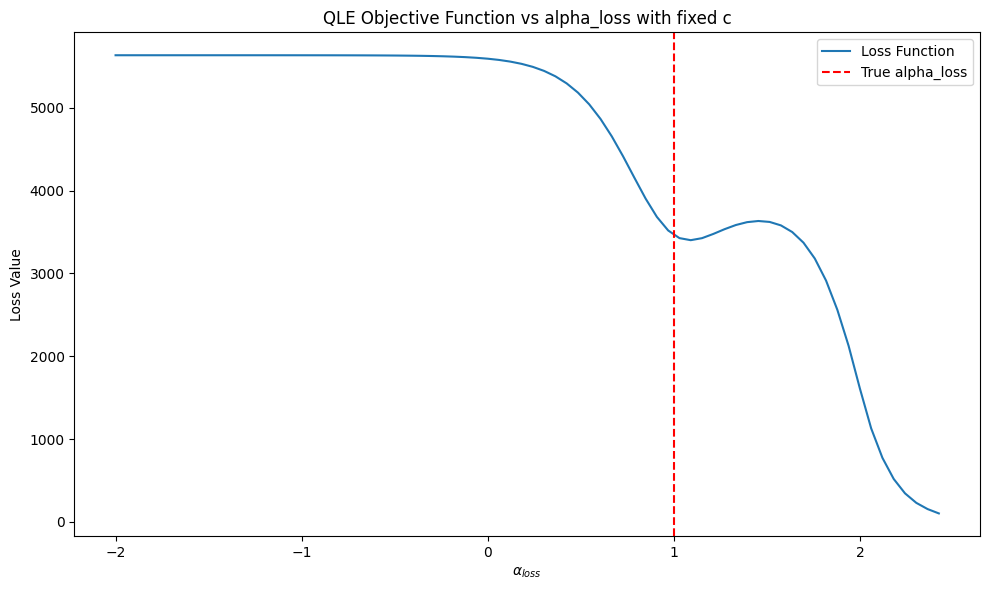

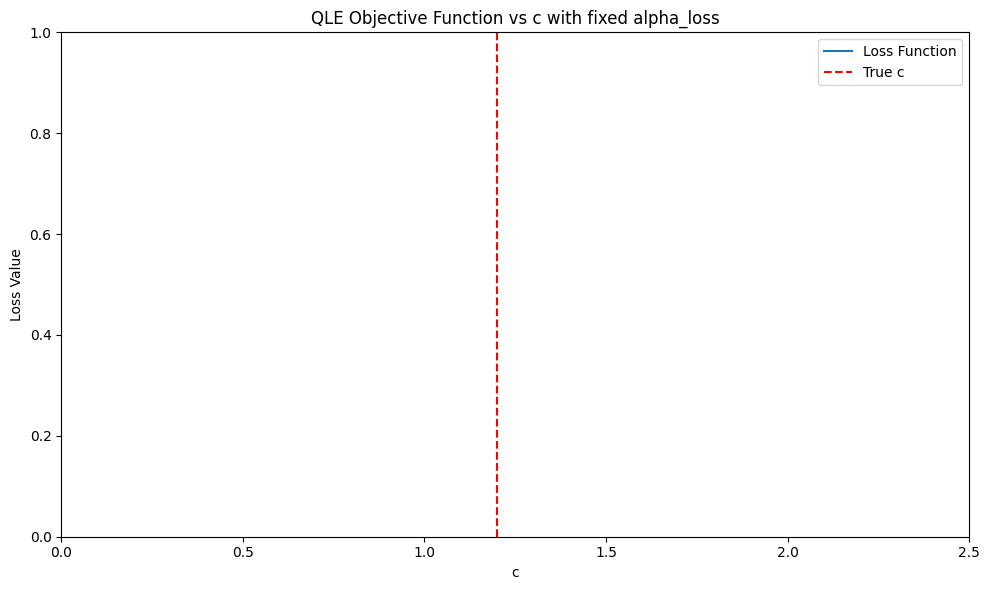

In [25]:

def load_and_preprocess_data(file_path, price_area='DK2'):
    """
    Load and preprocess electricity spot price data by splitting each day into 
    four quartiles and calculating the mean price for each quartile.
    
    This approach provides 4 observations per day instead of weekly Monday averages,
    capturing intraday price dynamics while maintaining temporal aggregation.
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing Nord Pool spot prices
    price_area : str
        Price area to filter for (e.g., 'DK1', 'DK2')
    
    Returns:
    --------
    y : numpy.ndarray
        Quartile time-series constructed by taking the mean electricity spot price 
        for each quartile of the day, taking logs and multiplying by 10
    quartile_prices : pandas.Series
        Quartile mean spot prices time series (for analysis)
    """
    import pandas as pd
    import numpy as np
    
    print(f"Loading Nord Pool electricity spot price data from: {file_path}")
    print("Methodology: Daily quartile time-series by taking mean spot price for each 6-hour period")
    
    # Load the dataset with proper separator
    try:
        df = pd.read_csv(file_path, sep=';')
        print(f"Data loaded successfully. Shape: {df.shape}")
        print(f"Date range: {df['HourDK'].min()} to {df['HourDK'].max()}")
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None
    
    # Fix datetime parsing
    df['HourDK'] = pd.to_datetime(df['HourDK'], errors='coerce')
    
    # Fix numeric columns - handle European decimal format (comma as decimal separator)
    print("Converting price columns to numeric...")
    
    def convert_european_decimal(series):
        """Convert European decimal format (comma as decimal separator) to float"""
        if series.dtype == 'object':
            # Replace comma with dot for decimal separator
            return pd.to_numeric(series.astype(str).str.replace(',', '.'), errors='coerce')
        else:
            return series
    
    # Convert price columns
    df['SpotPriceDKK'] = convert_european_decimal(df['SpotPriceDKK'])
    df['SpotPriceEUR'] = convert_european_decimal(df['SpotPriceEUR'])
    
    # Check for conversion issues
    dkk_na = df['SpotPriceDKK'].isna().sum()
    eur_na = df['SpotPriceEUR'].isna().sum()
    
    print(f"Price conversion complete. DKK NAs: {dkk_na}, EUR NAs: {eur_na}")
    
    if dkk_na > 0:
        print(f"Warning: {dkk_na} DKK prices could not be converted")
    if eur_na > 0:
        print(f"Warning: {eur_na} EUR prices could not be converted")
    
    # Check for parsing errors
    if df['HourDK'].isna().any():
        print(f"Warning: {df['HourDK'].isna().sum()} datetime parsing errors found")
        df = df.dropna(subset=['HourDK'])
    
    # Remove rows with invalid price data
    df = df.dropna(subset=['SpotPriceDKK'])
    
    # Filter for specific price area
    if price_area:
        available_areas = df['PriceArea'].unique()
        print(f"Available price areas: {available_areas}")
        
        if price_area not in available_areas:
            print(f"Warning: {price_area} not found. Using first available area: {available_areas[0]}")
            price_area = available_areas[0]
        
        df = df[df['PriceArea'] == price_area]
        print(f"Filtered for {price_area}. Remaining rows: {len(df)}")
    
    # Set datetime as index and filter date range
    df = df.set_index('HourDK')
    df = df[df.index > '2016-09-01']
    df = df[df.index < '2017-09-01']
    print(f"Date filtered data. Remaining rows: {len(df)}")
    
    # Create date and hour columns for quartile calculation
    df['Date'] = df.index.date
    df['Hour'] = df.index.hour
    
    # Define quartiles based on hour of day (0-23)
    # Quartile 1: 00:00-05:59 (hours 0-5)    - Night/Early Morning
    # Quartile 2: 06:00-11:59 (hours 6-11)   - Morning
    # Quartile 3: 12:00-17:59 (hours 12-17)  - Afternoon
    # Quartile 4: 18:00-23:59 (hours 18-23)  - Evening/Night
    
    def assign_quartile(hour):
        if 0 <= hour <= 5:
            return 1
        elif 6 <= hour <= 11:
            return 2
        elif 12 <= hour <= 17:
            return 3
        else:  # 18 <= hour <= 23
            return 4
    
    df['Quartile'] = df['Hour'].apply(assign_quartile)
    
    print("Daily quartile assignment:")
    print("Quartile 1: 00:00-05:59 (Night/Early Morning)")
    print("Quartile 2: 06:00-11:59 (Morning)")
    print("Quartile 3: 12:00-17:59 (Afternoon)")
    print("Quartile 4: 18:00-23:59 (Evening/Night)")
    
    # Calculate quartile means for each day
    quartile_data = df.groupby(['Date', 'Quartile'])['SpotPriceDKK'].mean().reset_index()
    
    # Create a proper datetime index for each quartile
    # We'll use the middle hour of each quartile as representative time
    quartile_hours = {1: 3, 2: 9, 3: 15, 4: 21}  # Representative hours for each quartile
    
    quartile_data['DateTime'] = pd.to_datetime(quartile_data['Date']) + \
                               pd.to_timedelta(quartile_data['Quartile'].map(quartile_hours), unit='h')
    
    # Set datetime as index and sort
    quartile_data = quartile_data.set_index('DateTime').sort_index()
    
    # Extract the price series
    quartile_prices = quartile_data['SpotPriceDKK']
    
    print(f"Quartile observations: {len(quartile_prices)} (should be ~4x daily observations)")
    print(f"Quartile price statistics - Min: {quartile_prices.min():.2f} DKK, Max: {quartile_prices.max():.2f} DKK, Mean: {quartile_prices.mean():.2f} DKK")
    
    # Check quartile distribution
    quartile_counts = quartile_data['Quartile'].value_counts().sort_index()
    print("Quartile distribution:")
    for q in [1, 2, 3, 4]:
        count = quartile_counts.get(q, 0)
        print(f"  Quartile {q}: {count} observations")
    
    # Remove any remaining NaN values
    quartile_prices = quartile_prices.dropna()
    print(f"After removing NaN: {len(quartile_prices)} quartile observations")
    
    if len(quartile_prices) == 0:
        print("Error: No valid quartile prices after preprocessing")
        return None, None
    
    # Handle negative or zero prices (if any)
    if (quartile_prices <= 0).any():
        print("Warning: Non-positive prices found. Adding small constant before log transform")
        quartile_prices = quartile_prices + abs(quartile_prices.min()) + 1
    
    # Apply transformation: take logs and multiply by 10
    log_prices = np.log(quartile_prices) * 10
    y_log = np.log(quartile_prices.values) *10 

    
    # Final time series
    y = y_log / np.std(y_log)  # Centering around mean for stability
    
    print(f"\nTransformation complete with quartile methodology:")
    print(f"- Daily time-series constructed by splitting each day into 4 quartiles (6-hour periods)")
    print(f"- Taking mean electricity spot price for each quartile")
    print(f"- Taking logs of quartile means and multiplying by 10")
    print(f"- Centering around mean for stability")
    print(f"Final array shape: {y.shape}")
    print(f"Transformed price statistics - Min: {y.min():.2f}, Max: {y.max():.2f}, Mean: {y.mean():.2f}")
    
    # Add quartile information to the series for later analysis
    quartile_prices_with_info = quartile_data[['SpotPriceDKK', 'Quartile']].copy()
    quartile_prices_with_info['LogTransformed'] = y
    
    return y, quartile_prices


def analyze_quartile_patterns(quartile_data):
    """
    Analyze price patterns across different quartiles of the day
    
    Parameters:
    -----------
    quartile_data : pandas.DataFrame
        DataFrame containing quartile price data
    
    Returns:
    --------
    analysis : dict
        Dictionary containing quartile analysis results
    """
    import pandas as pd
    import numpy as np
    
    # Group by quartile to analyze patterns
    quartile_stats = quartile_data.groupby('Quartile')['SpotPriceDKK'].agg([
        'count', 'mean', 'std', 'min', 'max', 'median'
    ]).round(2)
    
    print("\nQuartile Price Analysis:")
    print("=" * 60)
    print("Quartile 1 (00:00-05:59): Night/Early Morning")
    print("Quartile 2 (06:00-11:59): Morning") 
    print("Quartile 3 (12:00-17:59): Afternoon")
    print("Quartile 4 (18:00-23:59): Evening/Night")
    print("-" * 60)
    print(quartile_stats)
    
    # Calculate relative differences
    overall_mean = quartile_data['SpotPriceDKK'].mean()
    
    print(f"\nRelative to Overall Mean ({overall_mean:.2f} DKK):")
    print("-" * 40)
    for q in [1, 2, 3, 4]:
        q_mean = quartile_stats.loc[q, 'mean']
        diff_pct = ((q_mean - overall_mean) / overall_mean) * 100
        print(f"Quartile {q}: {diff_pct:+.1f}% ({q_mean:.2f} DKK)")
    
    return quartile_stats


def main_with_quartiles():
    """
    Main execution function using quartile-based preprocessing
    """
    # File path
    file_path = "/Users/MathijsDijkstra/Downloads/Elspotprices.csv"
    
    print("="*80)
    print("EMPIRICAL ILLUSTRATION: Nord Pool Electricity Spot Prices")
    print("QUARTILE-BASED ANALYSIS")
    print("="*80)
    print("Analyzing quartile electricity spot prices - 4 observations per day")
    print("Each day split into 6-hour periods for enhanced temporal resolution")
    print("-"*80)
    
    # Load and preprocess data with quartile approach
    y, quartile_prices = load_and_preprocess_data(file_path, price_area='DK2')
    
    if y is None:
        print("Failed to load and preprocess data. Exiting.")
        return None, None, None
    
    # Additional quartile analysis if we have the detailed data
    try:
        # Recreate quartile analysis data for pattern analysis
        print("\nPerforming quartile pattern analysis...")
        # This would require the detailed quartile_data from the function
        # For now, we'll show basic statistics
        
        print(f"\nBasic Time Series Statistics:")
        print(f"Total observations: {len(y)}")
        print(f"Expected daily observations: ~4 (one per quartile)")
        print(f"Approximate days covered: {len(y) // 4}")
        
    except Exception as e:
        print(f"Quartile analysis error: {e}")
    
    print("-"*80)
    print("QUARTILE DATA PREPROCESSING COMPLETE")
    print("-"*80)
    print("Ready for model fitting with enhanced temporal resolution")
    print(f"Time series length: {len(y)} quartile observations")
    
    return y, quartile_prices, None

y, monday_prices, _ = main_with_quartiles()

plt.plot(y)
plt.show()

c_val  = 1
#plot the function wrt to alpha_loss 
alpha_loss_values = np.linspace(-2, 4, 100)

loss_values = np.zeros_like(alpha_loss_values)

for j, alpha_val in enumerate(alpha_loss_values):
    model = RobustQLEVolatilityModel(alpha_loss=alpha_val, c=c_val)
    params = np.array([omega, gamma, beta, alpha_val, c_val])
    loss_values[j] = model._qle_objective(params, y)
plt.figure(figsize=(10, 6))
plt.plot(alpha_loss_values, loss_values, label='Loss Function')
plt.xlabel(r'$\alpha_{loss}$')
plt.ylabel('Loss Value')
plt.title('QLE Objective Function vs alpha_loss with fixed c')
plt.axvline(x=true_params['alpha_loss'], color='r', linestyle='--', label='True alpha_loss')
plt.legend()

plt.tight_layout()
plt.show()




# Plot the function wrt to c
 # Fixed alpha_loss value for this plot

c_values = np.linspace(0, 2, 100)
loss_values_c = np.zeros_like(c_values)
for i, c_val in enumerate(c_values):
    model = RobustQLEVolatilityModel(alpha_loss=alpha_val, c=c_val)
    params = np.array([omega, gamma, beta, alpha_val, c_val])
    loss_values_c[i] = model._qle_objective(params, y)
plt.figure(figsize=(10, 6))
plt.plot(c_values, loss_values_c, label='Loss Function')
plt.xlabel('c')
plt.xlim(0, 2.5)
plt.ylim(0, 1)
plt.ylabel('Loss Value')
plt.title('QLE Objective Function vs c with fixed alpha_loss')
plt.axvline(x=true_params['c'], color='r', linestyle='--', label='True c')
plt.legend()
plt.tight_layout()
plt.show()

# Step 5: Print the fixed parameters

